In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U tensorflow==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
     

In [4]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

2023-10-12 17:05:34.696487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 17:05:34.696550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 17:05:34.696608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


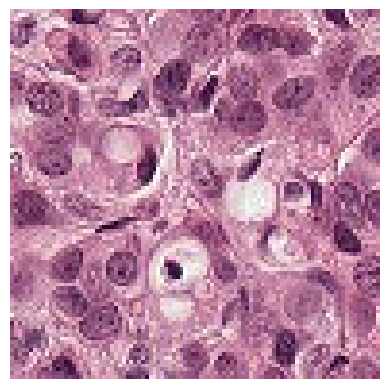

In [5]:
import tifffile as tff
import matplotlib.pyplot as plt

image_path = '/kaggle/input/histopathologic-cancer-detection/train/00043555aad4d531c165e1129d281aaca9316c45.tif'

image = tff.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
image.shape

(96, 96, 3)

In [7]:
def train_img_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

In [8]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [9]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
print(train_img_path(train_labels['id'][0]))

/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif


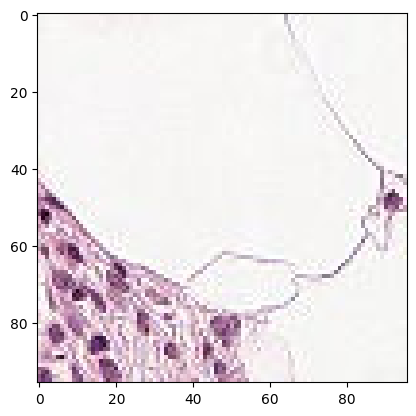

In [11]:
image = tff.imread('/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif')

plt.imshow(image)
plt.show()

In [12]:
train_labels['filename'] = train_labels['id'].apply(train_img_path)

In [13]:
train_labels.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [14]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)

for i in range(len(train_labels))[:100]:
    img_path = train_img_path(train_labels['id'][i])
    img = tff.imread(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels['label'][i]

No cancer images


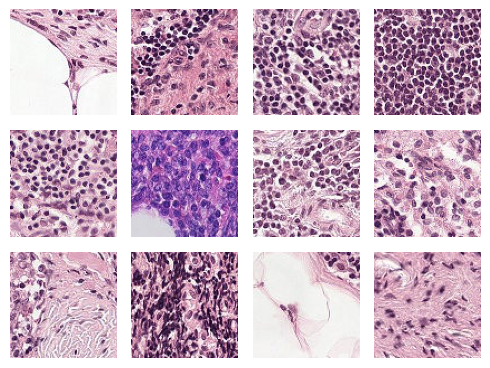

In [15]:
print('No cancer images')

random_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid, grid, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][random_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancer images


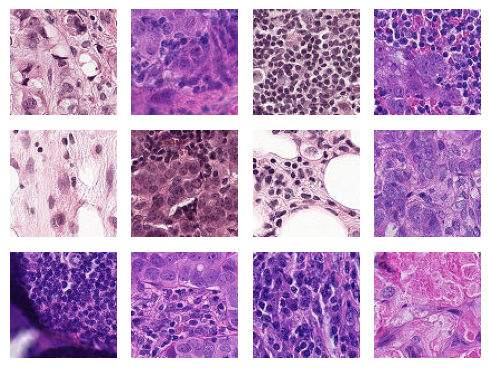

In [16]:
print('Cancer images')

random_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid, grid, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][random_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

In [17]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [18]:
import tensorflow as tf
from tensorflow import keras

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rescale=1/255,
    validation_split=0.2
)

In [20]:
train_labels['label'] = train_labels['label'].astype(str)

In [21]:
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [22]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 10
)

Found 57458 non-validated image filenames.


Transformed images


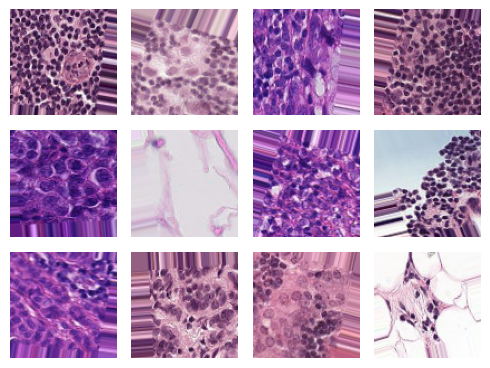

In [23]:
print('Transformed images')

batch = train_generator.next()

images, labels = batch

grid = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid, grid, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(images[i])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

In [24]:
batch_size = 32
epochs = 10
num_classes = 2

version = 1
n = 3

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


model_type = "ResNet % dv % d" % (depth, version)

input_shape = train_generator.image_shape

In [25]:
def residual_block(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True
):
    conv = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(1e-4)
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [26]:
from tensorflow.keras.initializers import glorot_uniform
from functools import partial

def ResidualNetwork(input_shape, depth, num_classes=2):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = Input(shape=input_shape)
    x = residual_block(inputs=inputs)
    
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = residual_block(inputs=x, num_filters=num_filters, strides=strides)
            y = residual_block(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:
                x = residual_block(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=None)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(1, kernel_initializer = glorot_uniform(seed=0))(y)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [27]:
input_shape

(96, 96, 3)

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

with strategy.scope():
    model = keras.models.Sequential()
    model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                            input_shape=[224, 224, 3]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(), 
        optimizer=tf.optimizers.Adam(learning_rate=0.001), 
        metrics=['accuracy']
    )

    model.summary()

In [29]:
with tf.keras.utils.custom_object_scope({'ResidualUnit': ResidualUnit}):
    strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
    with strategy.scope():
        loaded_model = tf.keras.models.load_model('/kaggle/input/modelepoch-1/best_model')

In [30]:
checkpoint = ModelCheckpoint(filepath='best_model', monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks=[checkpoint]

loaded_model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size=32,
    epochs=4,
    callbacks=callbacks
)

Epoch 1/4
5501/5501 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9117
Epoch 1: val_accuracy improved from -inf to 0.72774, saving model to best_model
5501/5501 [==============================] - 2620s 469ms/step - loss: 0.2248 - accuracy: 0.9117 - val_loss: 0.8120 - val_accuracy: 0.7277
Epoch 2/4
5501/5501 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9169
Epoch 2: val_accuracy improved from 0.72774 to 0.79589, saving model to best_model
5501/5501 [==============================] - 1729s 314ms/step - loss: 0.2129 - accuracy: 0.9169 - val_loss: 0.4604 - val_accuracy: 0.7959
Epoch 3/4
5501/5501 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9197
Epoch 3: val_accuracy improved from 0.79589 to 0.88531, saving model to best_model
5501/5501 [==============================] - 1351s 246ms/step - loss: 0.2042 - accuracy: 0.9197 - val_loss: 0.2878 - val_accuracy: 0.8853
Epoch 4/4
5501/5501 [============================

In [35]:
loaded_model.save('model')

1376/1376 [==============================] - 176s 128ms/step
Accuracy: 0.5263947278718327
Precision: 0.3940189239588369
Recall: 0.32101057843799236
F1 Score: 0.3537874794580013
ROC AUC: 0.4974376211780131
Confusion Matrix:
[[17459  8774]
 [12067  5705]]


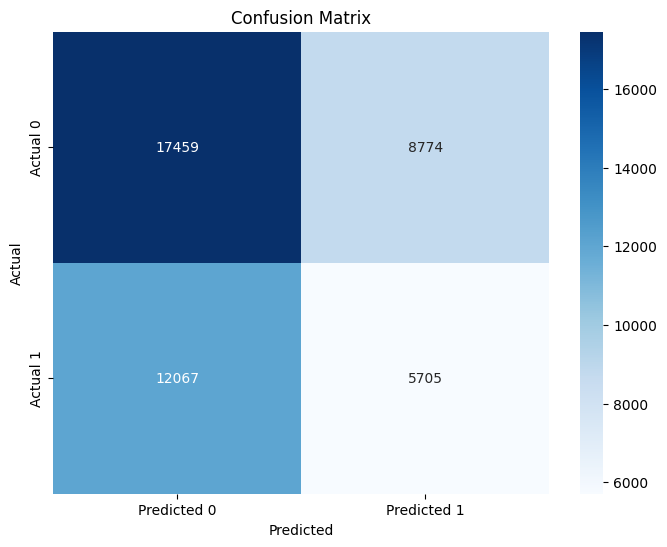

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = loaded_model.predict(validation_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
y_val = validation_generator.classes

accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
roc_auc = roc_auc_score(y_val, y_pred)

conf_matrix = confusion_matrix(y_val, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

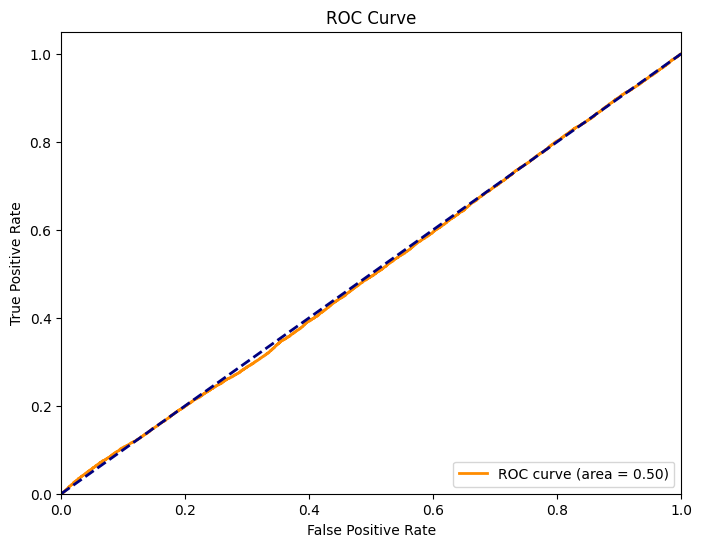

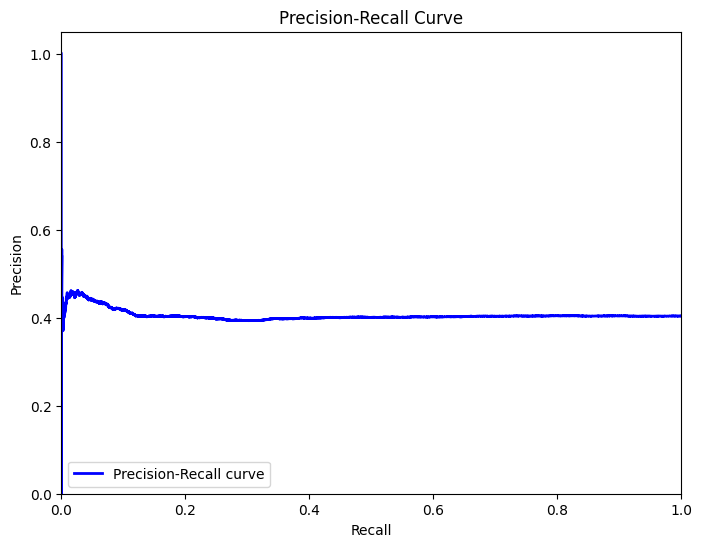

In [39]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_pred)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [41]:
test_probs = loaded_model.predict(test_generator)

898/898 [==============================] - 721s 801ms/step


In [42]:
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels
out_df.to_csv(os.path.join('/kaggle/working/', "test_labels.csv"), index=False)

In [43]:
import shutil
submission_file = r"/kaggle/working/test_labels.csv"
shutil.copy(submission_file, "submission.csv")

'submission.csv'